In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Pandas setting
pd.options.plotting.backend = "plotly"
pd.options.mode.chained_assignment = None

In [2]:
# Import dataset
df = pd.read_csv('datasets/theses_v2.csv', encoding='latin-1', low_memory=False)

In [3]:
import re

# Pre-processing
df.replace('', np.NaN, inplace=True)
df['Auteur'] = df['Auteur'].apply(lambda s: re.sub('\([^\)]+\)', '', s.title()).rstrip())

df['Identifiant auteur'] = df['Identifiant auteur'].apply(lambda x: str(x).replace(',', ''))
df['Identifiant auteur'].replace({'nan' : np.nan, '' : np.nan}, inplace = True)

df['Identifiant directeur'] = df['Identifiant directeur'].apply(lambda x: str(x).replace(',', ''))
df['Identifiant directeur'].replace({'na' : np.nan, '' : np.nan}, inplace = True)

df['Supervisor'] = df['Directeur de these (nom prenom)'].str.title()
df['Supervisor'].replace({'Directeur De These Inconnu' : np.nan}, inplace = True)
df.drop(columns=['Directeur de these', 'Directeur de these (nom prenom)'], inplace=True)

# Missing Data

Create number of pages column

In [4]:
from scipy.stats import bernoulli as bn

mu, sigma = 200, 50
pages = sigma * np.random.randn(1, df.shape[0]) + mu

flag = bn.rvs(p = 0.8, size = (1, df.shape[0]))
pages[flag == 0] = np.nan

df['nb_pages'] = pages.ravel() # Number of pages column

In [5]:
print(df.isna().mean().round(4) * 100)

Auteur                                       0.00
Identifiant auteur                          29.14
Titre                                        0.00
Identifiant directeur                       10.98
Etablissement de soutenance                  0.00
Identifiant etablissement                    3.82
Discipline                                   0.00
Statut                                       0.00
Date de premiere inscription en doctorat    85.71
Date de soutenance                          12.68
Year                                        12.68
Langue de la these                          14.24
Identifiant de la these                      0.00
Accessible en ligne                          0.00
Publication dans theses.fr                   0.00
Mise a jour dans theses.fr                   0.04
Supervisor                                   0.16
nb_pages                                    19.99
dtype: float64


Missing data plot

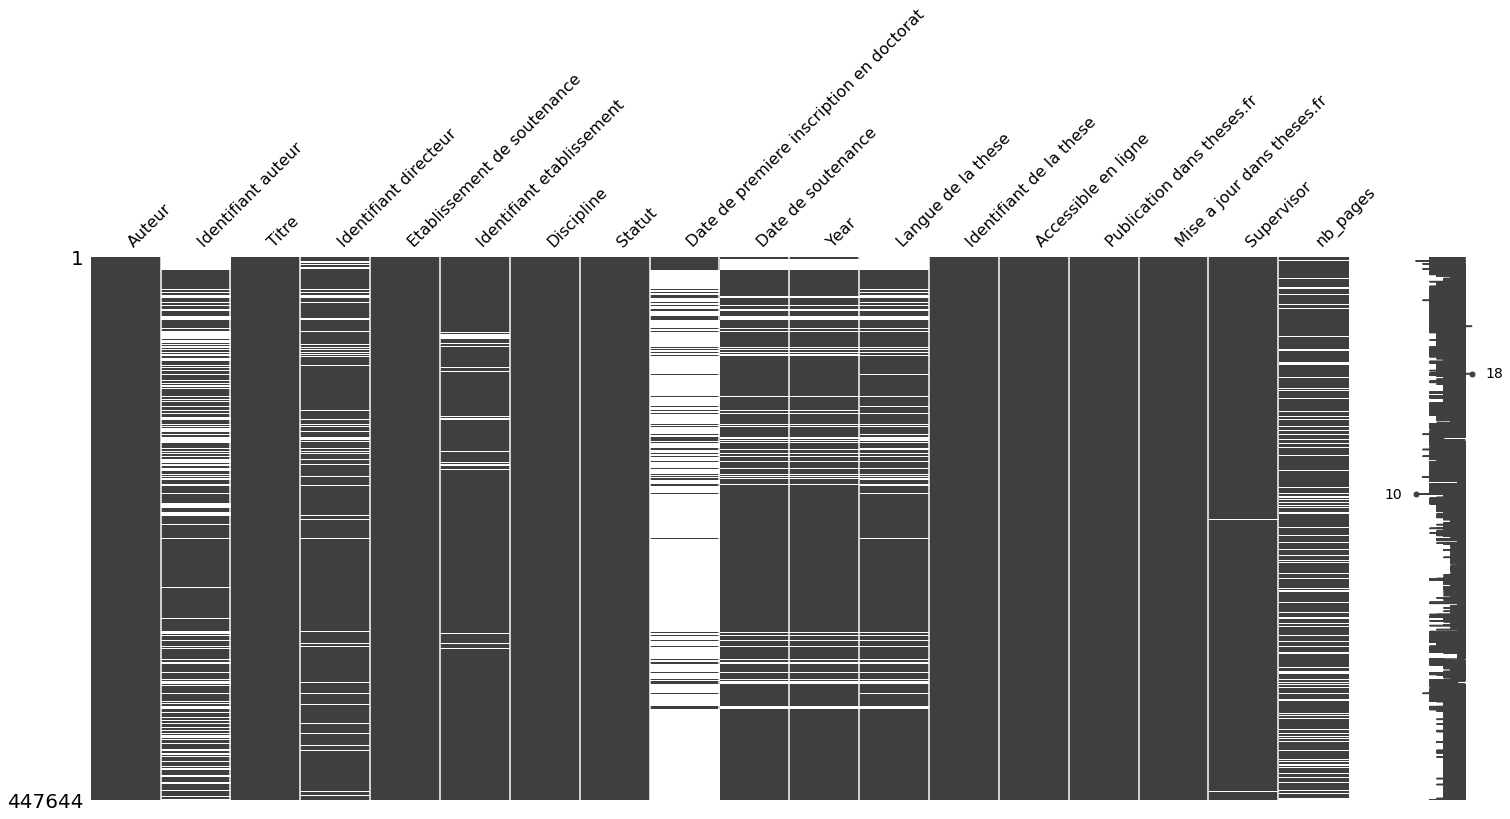

In [6]:
import missingno as msno

msno.matrix(df)
plt.savefig("plots/missing_plot.png")

Dealing with missing data using imputation technique

In [7]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['nb_pages'] = imp.fit_transform(df[['nb_pages']]).ravel()
df['nb_pages'] = df['nb_pages'].apply(int)

# Common issues

In [8]:
df_defences = df.dropna(subset=['Date de soutenance'])
df_defences['Date de soutenance'] = pd.DatetimeIndex(df_defences['Date de soutenance'])
df_defences['Month'] = df_defences['Date de soutenance'].apply(lambda x: x.month)

years = df_defences.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

### How common are the defences on the ﬁrst of January?

In [9]:
df_0101 = df_defences[df_defences['Date de soutenance'].apply(lambda x: np.logical_and(x.day == 1, x.month == 1))]

percentage_thesis_0101 = np.round(df_0101.shape[0] / df_defences.shape[0], 4) * 100
print(percentage_thesis_0101, '%')

71.89 %


### How did the proportion of defences at the ﬁrst of january evolve over the years ?

In [10]:
# Calculate percentage
df_0101 = df_0101.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1)
df_0101.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_0101['nb_Thesis_byyear'] = df_0101['Year'].apply(lambda x: years.loc[x])
df_0101['Percentage'] = df_0101['nb_Thesis'] / df_0101['nb_Thesis_byyear'] * 100

In [11]:

fig = df_0101.plot(x='Year', y='Percentage', title='Percentage of thesis defended on New Year\'s Day')
fig.write_image('plots/thesis_newyeareve.png')
fig.show()

### In the Author name, how common are homonyms ? Check for Cecile Martin. Investigate her case and try to ﬁgure out what happened.

In [12]:
print(df['Auteur'].duplicated(keep=False).mean().round(4) * 100,'%')

7.66 %


In [13]:
df['Auteur'].value_counts().head(10)

Philippe Martin    16
Nicolas Martin     16
Philippe Michel    13
Yang Liu           12
Franck Martin      12
Laurent Martin     11
Jing Wang          11
Pierre Martin      11
Olivier Martin     11
Yu Wang            11
Name: Auteur, dtype: int64

In [14]:
df[df['Auteur']== 'Cecile Martin'][['Identifiant auteur', 'Auteur', 'Year', 'Supervisor']]

,Identifiant auteur,Auteur,Year,Supervisor
61289,203208145,Cecile Martin,2017.0,Jullier Laurent
166820,81323557,Cecile Martin,2000.0,Lossouarn Jean
267565,179423568,Cecile Martin,2014.0,Dormont Brigitte
410228,81323557,Cecile Martin,2001.0,Antonini Gerard
414771,81323557,Cecile Martin,1991.0,Mironneau Jean
426351,81323557,Cecile Martin,1994.0,Briand Yves
432070,182118703,Cecile Martin,1989.0,Vautherin Dominique


There is a sudden drop in the number of PhD defended in 2019 and 2020. Propose 3 hypotheses to explain this phenomenon.

In [15]:
temp = df_defences.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1)
temp.rename(columns={'Titre' : 'Number Thesis'}, inplace=True)
fig = temp.plot(x='Year', y='Number Thesis', title='Thesis defended by Year')
fig.write_image('plots/nb_thesis_by_year.png')
fig.show()

In [16]:
# Latest defense in dataset
df_defences['Date de soutenance'].max()

Timestamp('2020-12-06 00:00:00')

# Outliers

Check Supervisor ID

In [17]:
df['Identifiant directeur'].value_counts().head(10)

1           1057
7            718
3            712
8            618
6            557
2            517
9            284
59375140     208
26730774     205
26756625     193
Name: Identifiant directeur, dtype: int64

In [18]:
df_outliers = df[df['Identifiant directeur'].str.len() == 1]
print(df_outliers.shape[0]) # Number of thesis supervised by top 7 ID

4587


In [19]:
print(df_outliers.groupby('Supervisor').count().shape[0]) # Number of different supervisors attached to 7 ID

4504


Investigate ID 59375140

In [20]:
df[df['Identifiant directeur'] == '59375140'].head(10)[['Identifiant directeur', 'Supervisor', 'Auteur', 'Titre', 'Year']]

,Identifiant directeur,Supervisor,Auteur,Titre,Year
90380,59375140,Scherrmann Jean-Michel,Ramzi Shawahna,Expression genomique et proteomique quantitati...,2011.0
91570,59375140,Scherrmann Jean-Michel,Leonor Vignol,Influence des variabilites pharmacocinetique e...,2001.0
97927,59375140,Scherrmann Jean-Michel,Anne J. Moulin Paccaly,Approches pharmacocinetiques/pharmacodynamique...,2005.0
98808,59375140,Scherrmann Jean-Michel,Sandrine Dauchy,"Expression, localisation et regulation des tra...",2008.0
103898,59375140,Scherrmann Jean-Michel,Severine Piot,Evaluation de 2 associations comportant du doc...,1999.0
104937,59375140,Scherrmann Jean-Michel,Sandrine Brami,Les interactions medicamenteuses avec les inhi...,1999.0
107340,59375140,Scherrmann Jean-Michel,Frederique Stain Texier,Contribution a la recherche du mecanime de l'a...,1999.0
112724,59375140,Scherrmann Jean-Michel,Pierre Got,Immuno-analyse et chiralite. Facteurs influenc...,1997.0
141777,59375140,Scherrmann Jean-Michel,Christophe Junot,Le tetrapeptide acetyl-seryl-aspartyl-lysyl-pr...,2000.0
144232,59375140,Scherrmann Jean-Michel,Stephane Lamy,Mise au point et validation d'une methode d'ul...,1999.0


Check Author ID

In [21]:
df['Identifiant auteur'].value_counts().head(10)

05990190X    12
69413916      7
85924660      6
069632472     6
60151013      6
56833776      5
27013340      5
34296565      5
78079365      5
66761999      5
Name: Identifiant auteur, dtype: int64

Investigate ID 05990190X

In [22]:
df[df['Identifiant auteur'] == '05990190X'][['Identifiant auteur', 'Auteur', 'Titre', 'Year', 'Supervisor']]

,Identifiant auteur,Auteur,Titre,Year,Supervisor
198300,05990190X,"Olivier Costerousse,Philippe Ascher",Regulation de l'expression du gene de l'enzyme...,1993.0,Alhenc-Gelas Francois
366482,05990190X,"Mohcine Bennani Mechita,Philippe Ascher",Analyse de la contribution de diverses regions...,1994.0,Elion Jacques
373880,05990190X,"Catherine Genevee-Gaudin,Philippe Ascher",Methodes d'etude du recepteur des lymphocytes ...,1993.0,Triebel Frederic
377636,05990190X,"Armelle Helene,Philippe Ascher",Analyse structurale du site actif de trois met...,1993.0,Roques B.
378116,05990190X,"Cecile Dufour,Philippe Ascher",Heterogeneite genetique de la cardiomyopathie ...,1995.0,Schwartz K.
389849,05990190X,"Thierry Galli,Philippe Ascher",N-acetyl-aspartyl-glutamate et ganglions de la...,1992.0,Glowinski Jacques
401866,05990190X,"Veronique Taupin,Philippe Ascher",Modulation de la production de cytokines pro-i...,1992.0,Zavala Flora
407053,05990190X,"Aymeric Duclert,Philippe Ascher",Contribution a l'etude de la regulation des ge...,1994.0,Changeux Jean-Pierre
417726,05990190X,Sylvie Dumas Milne Edwards De Vitry D'Avaucour...,Diversite des regulations de l'expression de l...,1993.0,Mallet Jacques
418298,05990190X,"Mohamed Machwate,Philippe Ascher",Etude de la formation osseuse dans un modele d...,1994.0,Marie P.


# Preliminary Results

## Languages and Defense day

In [23]:
# Extract only thesis that has language record from 2000
df_lang = df_defences.drop(df_defences[df_defences['Langue de la these'].isna()].index)
df_lang.drop(df_lang[df_lang['Year'] < 2000].index, inplace=True)

years = df_lang.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [24]:
# Categorize language column to English, French, Multilingual and Others.
df_lang['Langue de la these'] = df_lang['Langue de la these'].str.lower()

conditions  = [ df_lang['Langue de la these'] == 'en', df_lang['Langue de la these'] == 'fr',
                df_lang['Langue de la these'].str.len() > 2]
choices     = [ "English", 'French', 'Multilingual']

df_lang['Langue de la these'] = np.select(conditions, choices, default = 'Others')
years = df_lang.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [25]:
# Calculate percentage
df_lang = df_lang.groupby(['Year', 'Langue de la these']).count().reset_index().reindex(['Year', 'Langue de la these', 'Titre'], axis=1)
df_lang.rename(columns={'Titre' : 'nb_Thesis', 'Langue de la these' : 'Language'}, inplace=True)
df_lang['nb_Thesis_byyear'] = df_lang['Year'].apply(lambda x: years.loc[x])
df_lang['Percentage'] = df_lang['nb_Thesis'] / df_lang['nb_Thesis_byyear'] * 100

In [26]:
fig = px.bar(df_lang, x="Year", y="Percentage", color="Language", title="Language of thesis by Year")
fig.write_image("plots/language_by_year.png")
fig.show()

What period of the year do PhD candidates tend to defend?

In [27]:
# Extract only thesis that's defended from 2011
df_months = df_defences[df_defences['Date de soutenance'].apply(lambda x: np.logical_and(x.year > 2010, np.logical_or(x.day != 1, x.month != 1)))]

years = df_months.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [28]:
# Calculate percentage
df_months = df_months.groupby(['Year', 'Month']).count().reset_index().reindex(['Year', 'Month', 'Titre'], axis=1)
df_months.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_months['nb_Thesis_byyear'] = df_months['Year'].apply(lambda x: years.loc[x])
df_months['Percentage'] = df_months['nb_Thesis'] / df_months['nb_Thesis_byyear'] * 100
df_months['Time'] = pd.to_datetime(df_months[['Year', 'Month']].assign(day=1))

In [29]:
fig = df_months.plot(x='Time', y='Percentage', title='Percentage of thesis defended by month')
fig.write_image("plots/thesis_by_month.png")
fig.show()

In [30]:
fig = df_months.groupby('Month').mean().reset_index().plot.bar(x='Month', y='Percentage', title='Percentage of thesis defended during the year')
fig.write_image("plots/percentage_thesis_during_year.png")
fig.show()

## Gender

In [31]:
import gender_guesser.detector as gender

# Extract only thesis that's defended from 2000
df_gender = df_defences.drop(df_defences[df_defences['Year'] < 2000].index)

detector = gender.Detector()
df_gender[['first_name','last_name']] = df_gender['Auteur'].str.split(' ', 1, expand=True)
df_gender['Gender'] = df_gender['first_name'].apply(lambda s: detector.get_gender(s))
rename_dict = {'mostly_female': 'Female', 'mostly_male': 'Male', 'male' : 'Male', 'female' : 'Female'}
df_gender['Gender'].replace(rename_dict, inplace=True)
df_gender.drop(df_gender[np.logical_or(df_gender['Gender'] == 'unknown', df_gender['Gender'] == 'andy')].index, inplace=True)

years = df_gender.groupby('Year').count().reset_index().reindex(['Year', 'Titre'], axis=1).set_index('Year')

In [32]:
# Calculate percentage
df_gender = df_gender.groupby(['Year', 'Gender']).count().reset_index().reindex(['Year', 'Gender', 'Titre'], axis=1)
df_gender.rename(columns={'Titre' : 'nb_Thesis'}, inplace=True)
df_gender['nb_Thesis_byyear'] = df_gender['Year'].apply(lambda x: years.loc[x])
df_gender['Percentage'] = df_gender['nb_Thesis'] / df_gender['nb_Thesis_byyear'] * 100

In [33]:
fig = px.bar(df_gender, x="Year", y="Percentage", color="Gender", title="Gender of PhD candidates by Year")
fig.write_image("plots/gender_by_year.png")
fig.show()